In [1]:
from tqdm import tqdm
import numpy as np
import scipy
import os

In [2]:
def relative_norm(pos, cvec, global_mean):
    """
    pos is of shape (L, T, C), where L is the number of layers (plus 1),
    T is the length of positions, and C is the dimension of the positional embeddings.

    Returns
        np.array shaped (T, 4), columns screeNOT, stable rank, explained ratio, relative norm
    """
    L, types, T, C = pos.shape
    L, types, B, C = cvec.shape
    nseq = B // T

    result = np.zeros((L, types, 4))
    for l in tqdm(range(L)):
        for t in range(types):
            p = pos[l, t]
            c = cvec[l, t]
            g = global_mean[l, t]
            p_full = np.concatenate([p for _ in range(nseq)])
            m = p_full + c + g

            result[l, t, 0] = scipy.linalg.norm(p_full, ord=2)
            result[l, t, 1] = scipy.linalg.norm(c, ord=2)
            result[l, t, 2] = scipy.linalg.norm(m - g, ord=2)
            result[l, t, 3] = scipy.linalg.norm(m, ord=2)
    return result


def load_pos_cvec_global_mean(dataset, model, root_dir="out"):
    data_dir = os.path.join(root_dir, f"{model}-{dataset}")
    suffix = "id1-512_none_train.npy"
    global_mean = np.load(os.path.join(data_dir, f"global_mean_{suffix}"))
    pos = np.load(os.path.join(data_dir, f"pos_{suffix}"))

    L, types, T, C = pos.shape
    N = 8 * T if model == "llama2" else 32 * T
    cvec = np.memmap(
        os.path.join(data_dir, f"cvec_{suffix}"),
        mode="r",
        shape=(L, types, N, C),
        dtype=np.float32,
    )
    return pos, cvec, global_mean

In [3]:

pos, cvec, global_mean = load_pos_cvec_global_mean("openwebtext", "gpt2")
R = relative_norm(pos, cvec, global_mean)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [02:08<00:00, 10.70s/it]


In [4]:
R.shape

titles = """
x0 = block.ln_1(x)
x1 = block.attn(x0)
x2 = x + x1
x3 = block.ln_2(x2)
x4 = block.mlp(x3)
x5 = x2 + x4
""".strip().splitlines()

titles

['x0 = block.ln_1(x)',
 'x1 = block.attn(x0)',
 'x2 = x + x1',
 'x3 = block.ln_2(x2)',
 'x4 = block.mlp(x3)',
 'x5 = x2 + x4']

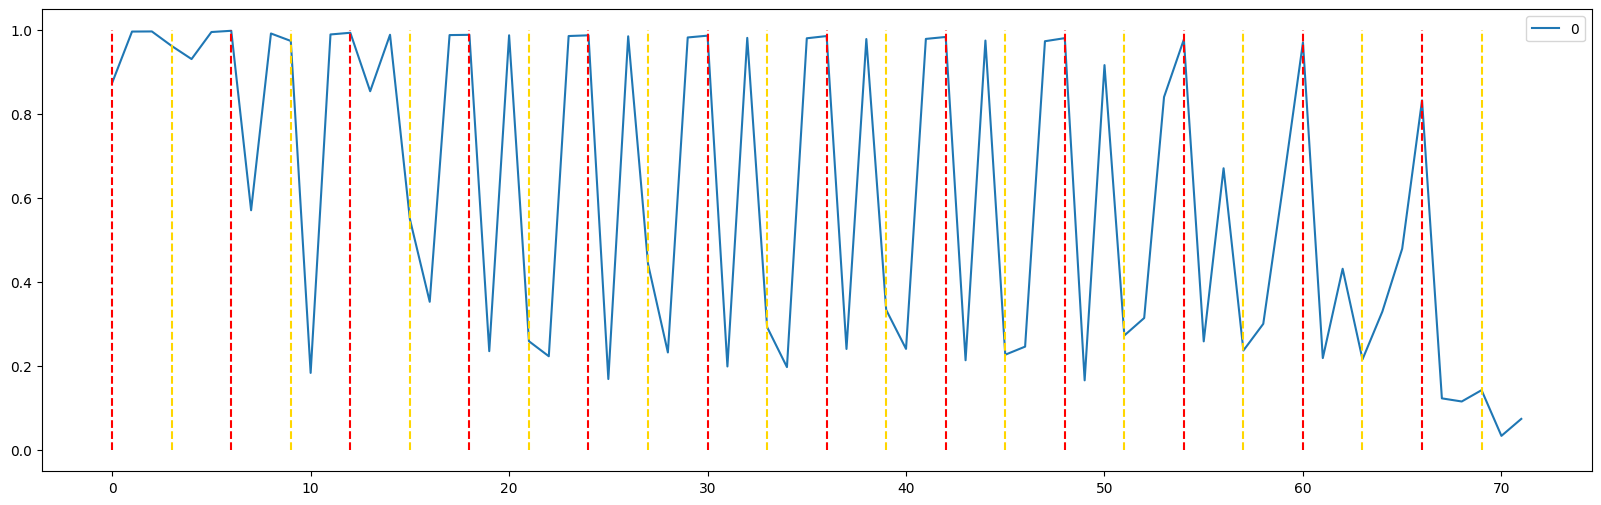

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# for type_idx in range(6):
#     R_ = R[:, type_idx, :-1]
#     pd.DataFrame(R_, columns=["p", "c", "m-g"]).plot(logy=True)
#     plt.title(titles[type_idx])
#     plt.show()
"""
['x0 = block.ln_1(x)',
 'x1 = block.attn(x0)',
 'x2 = x + x1',
 'x3 = block.ln_2(x2)',
 'x4 = block.mlp(x3)',
 'x5 = x2 + x4']
"""
R_ = R.reshape(12*6, 4)
R_ = R_[:, 0] / R_[:, 2]
pd.DataFrame(R_).plot(figsize=(20, 6))
for xx in range(0, 72, 6):
    plt.vlines(xx, linestyles="dashed", colors="red", ymin=0, ymax=1)
for xx in range(3, 72, 6):
    plt.vlines(xx, linestyles="dashed", colors="gold", ymin=0, ymax=1)
pass

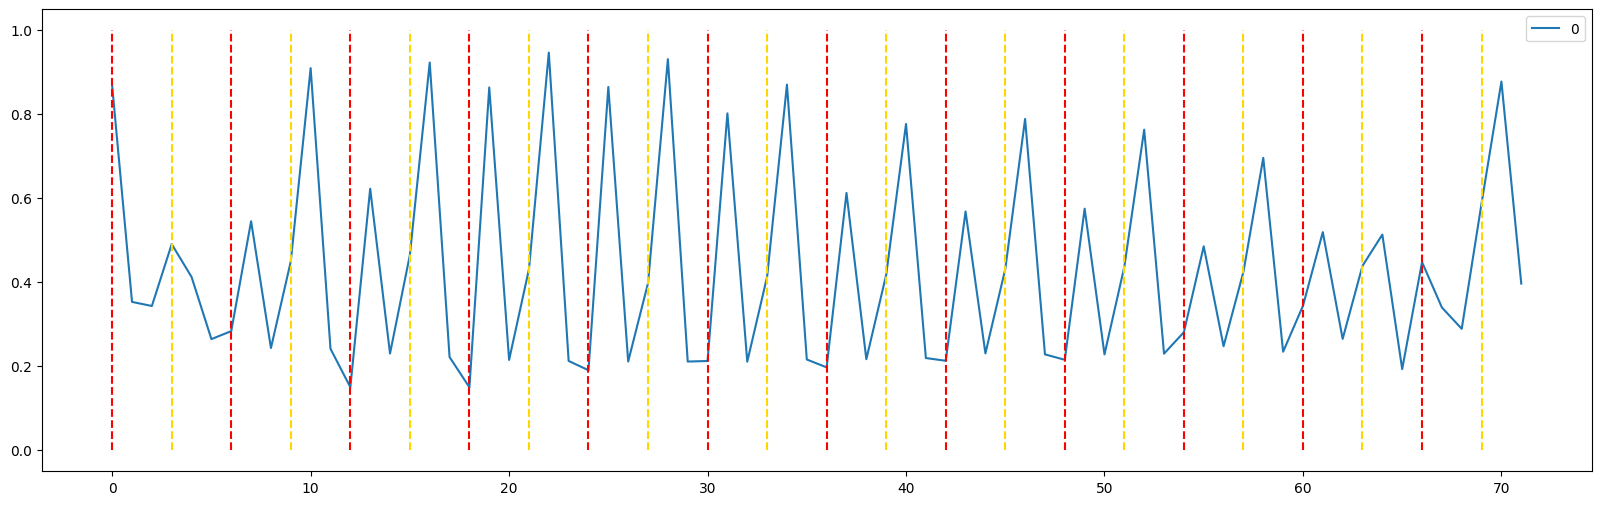

In [9]:
R_ = R.reshape(12*6, 4)
R_ = R_[:, 1] / R_[:, 3]
pd.DataFrame(R_).plot(figsize=(20, 6))
for xx in range(0, 72, 6):
    plt.vlines(xx, linestyles="dashed", colors="red", ymin=0, ymax=1)
for xx in range(3, 72, 6):
    plt.vlines(xx, linestyles="dashed", colors="gold", ymin=0, ymax=1)
pass

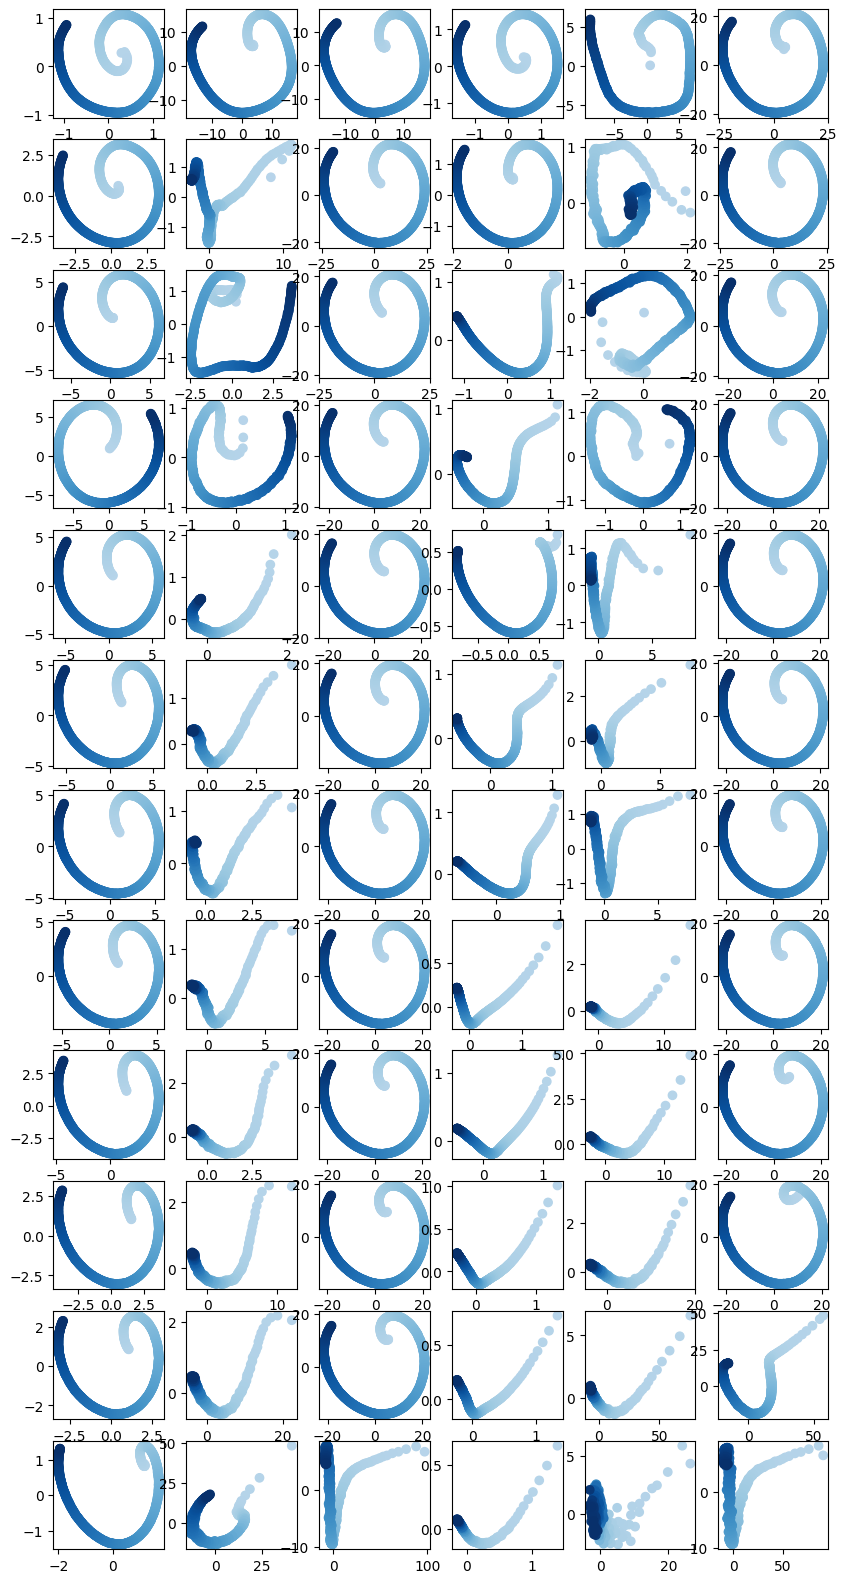

In [46]:
fig, ax = plt.subplots(12, 6, figsize=(10, 20))
for layer in range(12):
    for type in range(6):
        p = pos[layer, type]
        T = p.shape[0]
        u, s, vt = np.linalg.svd(p)
        pc2 = p @ vt[:2, :].T
        colors_blue = [plt.cm.Blues(x) for x in np.linspace(0.3, 1, T)]
        ax[layer][type].scatter(pc2[:, 0], pc2[:, 1], c=colors_blue)

plt.savefig("Figures/gpt-openwebtext/pos.png")

In [ ]:
cvec.shape

In [47]:
fig, ax = plt.subplots(12, 6, figsize=(10, 20))
for layer in range(12):
    for type in range(6):
        c = cvec[layer, type]
        N = c.shape[0]
        u, s, vt = np.linalg.svd(c)
        pc2 = p @ vt[:2, :].T
        colors_blue = [plt.cm.Blues(x) for x in np.linspace(0.3, 1, N)]
        ax[layer][type].scatter(pc2[:, 0], pc2[:, 1], c=colors_blue)

plt.savefig("Figures/gpt-openwebtext/cvec.png")